# Deployment and Inference on SageMaker Endpoint for Hypertension

---
This notebook demonstrates the use of Amazon SageMaker [AutoGluon-Tabular](https://auto.gluon.ai/stable/tutorials/tabular_prediction/index.html) algorithm to train and host a tabular binary classification model. Tabular classification is the task of assigning a class to an example of structured or relational data. The Amazon SageMaker API for tabular classification can be used for classification of an example in two classes (binary classification) or more than two classes (multi-class classification).


In this notebook, we demonstrate two use cases of tabular classification models:

* How to train a tabular model on a multimodal dataset to do binary classification. This notebook classifies Hypertension as an example. A similar approach can be used for predicting other diseases.
* How to use the trained tabular model to perform inference, i.e., classifying new samples.

Note: This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Train A Tabular Model on Adult Dataset](#2.-Train-a-Tabular-Model-on-Adult-Dataset)
    * [Retrieve Training Artifacts](#2.1.-Retrieve-Training-Artifacts)
    * [Set Training Parameters](#2.2.-Set-Training-Parameters)
    * [Start Training](#2.3.-Start-Training)
3. [Deploy and Run Inference on the Trained Tabular Model](#3.-Deploy-and-Run-Inference-on-the-Trained-Tabular-Model)
4. [Evaluate the Prediction Results Returned from the Endpoint](#4.-Evaluate-the-Prediction-Results-Returned-from-the-Endpoint)

## 1. Set Up

In [27]:
# Get data type to train model

data_type = 'genomic-clinical-imaging'
PatientID = 'patientid'

In [28]:
# Set up S3 buckets and session

import boto3
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role

sm_session = sagemaker.Session()
bucket = sm_session.default_bucket()
region = boto3.Session().region_name
role = get_execution_role()
aws_role = sm_session.get_caller_identity_arn()

boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

s3_client = boto3.client('s3', region_name=region)

default_s3_bucket_name = sm_session.default_bucket()
prefix = 'multi-model-health-ml'

print(default_s3_bucket_name)


sagemaker-us-east-1-659535263284


In [29]:
# Get features from SageMaker FeatureStore based on data type

from sagemaker.feature_store.feature_group import FeatureGroup

genomic_feature_group_name = 'genomic-feature-group'
clinical_feature_group_name = 'clinical-feature-group'
imaging_feature_group_name = 'imaging-feature-group'

genomic_feature_group = FeatureGroup(name=genomic_feature_group_name, sagemaker_session=feature_store_session)
clinical_feature_group = FeatureGroup(name=clinical_feature_group_name, sagemaker_session=feature_store_session)
imaging_feature_group = FeatureGroup(name=imaging_feature_group_name, sagemaker_session=feature_store_session)

genomic_query = genomic_feature_group.athena_query()
clinical_query = clinical_feature_group.athena_query()
imaging_query = imaging_feature_group.athena_query()

genomic_table = genomic_query.table_name
clinical_table = clinical_query.table_name
imaging_table = imaging_query.table_name

print('Table names')
print(genomic_table)
print(clinical_table)
print(imaging_table)

Table names
genomic_feature_group_1688073848
clinical_feature_group_1688073736
imaging_feature_group_1692317426


In [30]:
# Select features from all 3 modalities - clinical, genomic, and imaging

def get_features(data_type, output_location):   
    if (data_type == 'genomic-clinical-imaging'):
        query_string = f'''SELECT * FROM "{genomic_table}", "{clinical_table}", "{imaging_table}"
                           WHERE "{genomic_table}".{PatientID} = "{clinical_table}".{PatientID}
                           AND "{genomic_table}".{PatientID} = "{imaging_table}".{PatientID}
                           ORDER BY "{clinical_table}".{PatientID} ASC'''                   
        print(query_string)
        
        genomic_query.run(query_string=query_string, output_location=output_location)
        genomic_query.wait()
        dataset = genomic_query.as_dataframe()
        
    elif data_type not in supported_data_type:
        raise KeyError(f'data_type {data_type} is not supported for this analysis.')
        
    return dataset

In [37]:
# Create a csv file with all the features extracted

fs_output_location = f's3://{default_s3_bucket_name}/{prefix}/feature-store-queries'
dataset = get_features(data_type, fs_output_location)
dataset = dataset.astype(str).replace({"{":"", "}":""}, regex=True)

# Write to csv in S3 without headers and index column.
filename=f'{data_type}-dataset.csv'
dataset_uri_prefix = f's3://{default_s3_bucket_name}/{prefix}/training_input/';

dataset.to_csv(filename, index=False)
s3_client.upload_file(filename, default_s3_bucket_name, f'{prefix}/training_input/{filename}')

SELECT * FROM "genomic_feature_group_1688073848", "clinical_feature_group_1688073736", "imaging_feature_group_1692317426"
                           WHERE "genomic_feature_group_1688073848".patientid = "clinical_feature_group_1688073736".patientid
                           AND "genomic_feature_group_1688073848".patientid = "imaging_feature_group_1692317426".patientid
                           ORDER BY "clinical_feature_group_1688073736".patientid ASC


INFO:sagemaker:Query 42a968c7-f324-46a5-8a43-6f102f19ff87 is being executed.
INFO:sagemaker:Query 42a968c7-f324-46a5-8a43-6f102f19ff87 successfully executed.


In [43]:
#Splitting data into training and testing 80:20

dataset = dataset.drop(columns = ['patientid', 'alzheimers_prediction', 'coronary_heart_disease_prediction', 'stroke_prediction', 'eventtime', 'write_time', 'api_invocation_time', 'is_deleted', 'eventtime.1', 'write_time.1', 'api_invocation_time.1', 'is_deleted.1', 'alzheimers_prediction.1',
                                    'coronary_heart_disease_prediction.1', 'stroke_prediction.1', 'hypertension_prediction.1', 'patientid.1', 'eventtime.2', 'write_time.2', 'api_invocation_time.2', 'is_deleted.2', 
                                   'alzheimers_prediction.2', 'coronary_heart_disease_prediction.2', 'stroke_prediction.2', 'hypertension_prediction.2', 'patientid.2', 'deceaseddatetime', 'medicationdate'])

dataset = dataset.astype(str).dropna()
training_data = dataset.sample(frac=0.8, random_state=25)
testing_data = dataset.drop(training_data.index)
print("Training size = ", len(training_data))
print("Out of sample testing size = ", len(testing_data))

# Modifying the dataset to have the target column i.e., hypertension_prediction as the first column

training_target = training_data.pop("hypertension_prediction")
training_data.insert(0, 'hypertension_prediction', training_target)
testing_target = testing_data.pop("hypertension_prediction")
testing_data.insert(0, 'hypertension_prediction', testing_target)


training_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, training_data.shape[1])]
training_data.to_csv(f's3://{default_s3_bucket_name}/hypertension_sagemaker/train/data.csv', index=False)

testing_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, training_data.shape[1])]
testing_data.to_csv(f's3://{default_s3_bucket_name}/multimodal_hypertension_testing_data.csv', index=False)

Training size =  121
Out of sample testing size =  30


## 2. Train a Tabular Model on Multimodal Dataset

---
In this demonstration, we will train a tabular algorithm on the multimodal dataset. If you want to bring your own dataset, below are the instructions on how the training data should be formatted as input to the model.

A S3 path should contain two sub-directories 'train/', and 'validation/' (optional). Each sub-directory contains a 'data.csv' file.

* The 'data.csv' files under sub-directory 'train/' and 'validation/' are for training and validation, respectively. The validation data is used to compute a validation score at the end of each training iteration or epoch. An early stopping is applied when the validation score stops improving. If the validation data is not provided, a fraction of training data is randomly sampled to serve as the validation data. The fraction value is selected based on the number of rows in the training data. Default values range from 0.2 at 2,500 rows to 0.01 at 250,000 rows. For details, see [AutoGluon-Tabular Documentation](https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor.fit).
* The first column of the 'data.csv' should have the corresponding target variable. The rest of other columns should have the corresponding predictor variables (features).
* All the categorical and numeric features, and target can be kept as their original formats.

Citations:

- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

### 2.1. Retrieve Training Artifacts

___

Here, we retrieve the training docker container, the training algorithm source, and the tabular algorithm. Note that model_version="*" fetches the latest model.

For the training algorithm, we have one choice in this demonstration.
* [AutoGluon-Tabular](https://auto.gluon.ai/stable/tutorials/tabular_prediction/index.html): To use this algorithm, specify `train_model_id` as `autogluon-classification-ensemble` in the cell below.

---

In [44]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = (
    "autogluon-classification-ensemble",
    "*",
    "training",
)
training_instance_type = "ml.p3.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune. In tabular case, however, the pre-trained model tarball is dummy and fine-tune means training from scratch.
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


### 2.2. Set Training Parameters

---

Now that we are done with all the setup that is needed, we are ready to train our tabular algorithm. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training.

The second set of parameters are algorithm specific training hyper-parameters. 

---

In [45]:
# Sample training data is available in this bucket
training_data_bucket = default_s3_bucket_name
training_data_prefix = "hypertension_sagemaker/train/data.csv"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sm_session.default_bucket()
output_prefix = "hypertension-deployment"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"
print(training_dataset_s3_path)

s3://sagemaker-us-east-1-659535263284/hypertension_sagemaker/train/data.csv


---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [46]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["auto_stack"] = "True"
print(hyperparameters)

{'eval_metric': 'auto', 'presets': 'medium_quality', 'auto_stack': 'True', 'num_bag_folds': '0', 'num_bag_sets': '1', 'num_stack_levels': '0', 'refit_full': 'False', 'set_best_to_refit_full': 'False', 'save_space': 'False', 'verbosity': '2'}


### 2.3. Start Training

---
We start by creating the estimator object with all the required assets and then launch the training job.
Note. We do not use hyperparameter tuning for AutoGluon models because [AutoGluon](https://arxiv.org/abs/2003.06505) succeeds by ensembling multiple models and stacking them in multiple layers rather than focusing on model/hyperparameter selection.

---

In [47]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-example-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)


# Launch a SageMaker Training job by passing s3 path of the training data
tabular_estimator.fit({"training": training_dataset_s3_path}, logs=True, job_name=training_job_name)

INFO:sagemaker:Creating training-job with name: jumpstart-example-autogluon-classificat-2023-08-23-19-19-55-442


2023-08-23 19:19:55 Starting - Starting the training job......
2023-08-23 19:20:35 Starting - Preparing the instances for training......
2023-08-23 19:21:51 Downloading - Downloading input data...
2023-08-23 19:22:16 Training - Downloading the training image........................
2023-08-23 19:26:07 Training - Training image download completed. Training in progress...2023-08-23 19:26:34,728 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2023-08-23 19:26:34,757 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"auto_stack":"True","eval_metric":"auto","num_bag_folds":"0","num_bag_sets":"1","num_stack_levels":"0","presets":"medium_quality","refit_full":"False","save_space":"False","set_best_to_refit_full":"False","verbosity":"2"}', 'SM_USER_ENTRY_POINT': 'transfer_learning.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_group_nam

## 3. Deploy and Run Inference on the Trained Tabular Model

---

In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output the probability of the sample for each class in the model. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others.
We start by retrieving the artifacts and deploying the `tabular_estimator` that we trained.

---

In [48]:
inference_instance_type = "ml.m5.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = tabular_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-659535263284/hypertension-deployment/output/jumpstart-example-autogluon-classificat-2023-08-23-19-19-55-442/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/autogluon/inference/classification/v1.0.0/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-659535263284/sagemaker-jumpstart-2023-08-23-19-28-39-522/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-08-23-19-28-39-522
INFO:sagemaker:Creating endpoint-config with name jumpstart-example-autogluon-classificat-2023-08-23-19-28-39-522
INFO:sagemaker:Creating endpoint with name jumpstart-example-autogluon-classificat-2023-08-23-19-28-39-522


----!

---
Next, we download the hold-out test data from the S3 bucket for inference.

---

In [49]:
jumpstart_assets_bucket = default_s3_bucket_name
test_data_file_name = "multimodal_hypertension_testing_data.csv"

boto3.client("s3").download_file(
    jumpstart_assets_bucket, test_data_file_name, test_data_file_name
)

---
Next, we read the  test data into pandas data frame, prepare the ground truth target and predicting features to send into the endpoint.

Below is the screenshot of the first 5 examples in the Adult test set. All of the test examples with features
from ```Feature_0``` to ```Feature_13``` are sent into the deployed model to get model predictions,
to estimate the ground truth ```target``` column. For each test example, the model will output
a vector of ```num_classes``` elements, where each element is the probability of the example for each class in the model.
The ```num_classes``` is 2 in this case. Next, the predicted class label is obtained by taking the class label
with the maximum probability over others. 

---

In [50]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# read the data
test_data = pd.read_csv(test_data_file_name, header=0, index_col=False)
test_data = test_data.loc[:, ~test_data.columns.str.contains('^Unnamed')]

test_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(5)

The test dataset contains 30 examples and 143 columns.

The first 5 observations of the data:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_133,Feature_134,Feature_135,Feature_136,Feature_137,Feature_138,Feature_139,Feature_140,Feature_141,Feature_142
0,0,"'SOD3', None, 'TNF', 'LPL', 'F5', 'PON1', 'PPA...",'Conflicting_interpretations_of_pathogenicity'...,"'14', '9', '6', '16', '17', '8', '10', '11', '...","53767041, 44919688, 12351625, 31667848, 449086...","'T', 'G', 'A', 'C'","'[A]', '[C]', '[G]', '[T]'",False,"'[1, 1]', '[0, 1]'",'Complete blood count (hemogram) panel - Blood...,...,0.000036,8.786080,0.908721,0.127636,2.138414,4.342449e-07,1.591756e+08,2.321636,9.241749,'e5e2ccf0487eed5523395431675fa708'
1,0,"'SOD3', None, 'TNF', 'LPL', 'F5', 'PON1', 'PPA...",'Conflicting_interpretations_of_pathogenicity'...,"'14', '9', '6', '16', '17', '8', '10', '11', '...","53767041, 44919688, 12351625, 31667848, 449086...","'T', 'G', 'A', 'C'","'[A]', '[C]', '[G]', '[T]'",False,"'[1, 1]', '[0, 1]'",'Complete blood count (hemogram) panel - Blood...,...,0.000036,8.840513,0.912763,0.120036,2.155856,4.356029e-07,1.627388e+08,2.638066,8.776968,'41b14124cdd7f0ea3d459bcfe6120e7f'
2,0,"'SOD3', None, 'TNF', 'LPL', 'F5', 'PON1', 'PPA...",'Conflicting_interpretations_of_pathogenicity'...,"'14', '9', '6', '16', '17', '8', '10', '11', '...","53767041, 44919688, 12351625, 31667848, 449086...","'T', 'G', 'A', 'C'","'[A]', '[C]', '[G]', '[T]'",False,"'[1, 1]', '[0, 1]'",'Complete blood count (hemogram) panel - Blood...,...,0.000040,8.799924,0.909517,0.125992,2.172186,4.332938e-07,1.631360e+08,2.395452,9.362557,'2f4e1bcf5b4a5959488886f23f971fff'
3,1,"'SOD3', None, 'TNF', 'LPL', 'F5', 'PON1', 'PPA...",'Conflicting_interpretations_of_pathogenicity'...,"'14', '9', '6', '16', '17', '8', '10', '11', '...","53767041, 44919688, 31667848, 12351625, 449086...","'T', 'G', 'A', 'C'","'[A]', '[C]', '[G]', '[T]'",False,"'[1, 1]', '[0, 1]'","'History and physical note', 'Comprehensive me...",...,0.000038,8.796959,0.909702,0.125534,2.272618,4.347583e-07,1.482052e+08,2.471419,8.319247,'72521baacf61e4df3fa0f73f6fb5d409'
4,0,"'SOD3', None, 'TNF', 'LPL', 'F5', 'PON1', 'PPA...",'Conflicting_interpretations_of_pathogenicity'...,"'14', '9', '6', '16', '17', '8', '10', '11', '...","53767041, 44919688, 12351625, 31667848, 449086...","'T', 'G', 'A', 'C'","'[A]', '[C]', '[G]', '[T]'",False,"'[1, 1]', '[0, 1]'","'History and physical note', 'Genetic analysis...",...,0.000035,8.789543,0.908239,0.128413,2.184209,4.327835e-07,1.543321e+08,2.396125,8.974533,'1c6f063d63badb2396674e7110da26f2'


---
The following code queries the endpoint you have created to get the prediction for each test example. 
The `query_endpoint()` function returns an array-like of shape (num_examples, num_classes), where each row indicates
the probability of the example for each class in the model. The num_classes is 2 in above test data.
Next, the predicted class label is obtained by taking the class label with the maximum probability over others for each example. 

---

In [53]:
import json
content_type = "text/csv"


def query_endpoint(encoded_tabular_data):
    # endpoint_name = endpoint_name
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = model_predictions["probabilities"]
    return np.array(predicted_probabilities)


# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob.append(predict_prob_batch)


predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(predict_prob, axis=1)

## 4. Evaluate the Prediction Results Returned from the Endpoint

---
We evaluate the predictions results returned from the endpoint by following two ways.

* Visualize the predictions results by plotting the confusion matrix.

* Measure the prediction results quantitatively.

---

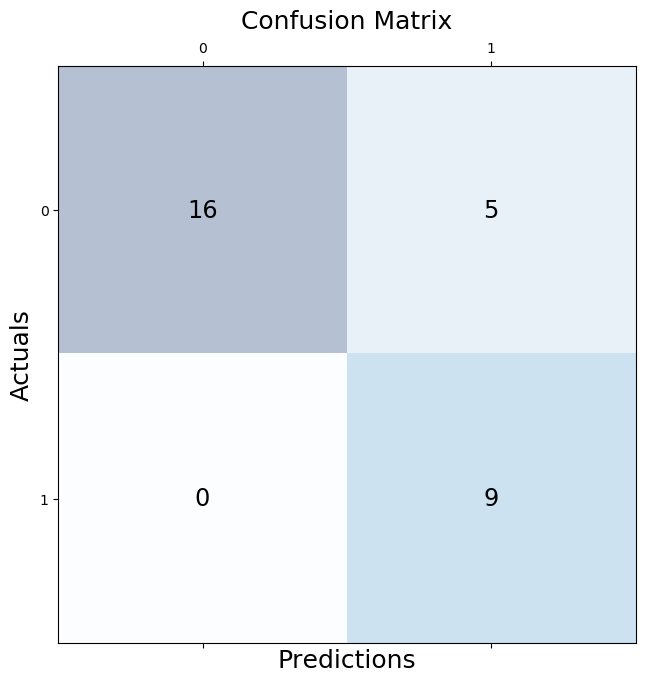

In [54]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [55]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1 = f1_score(ground_truth_label.values, predict_label)

print(
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy}{newline}"
    f"{bold}F1 {unbold}: {eval_f1}{newline}"
)

Evaluation result on test data:
accuracy_score: 0.8333333333333334
F1 : 0.782608695652174



---
Next, we delete the endpoint corresponding to the trained model.

---

In [ ]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()